<a href="https://colab.research.google.com/github/AL-Jalili/Anchusa_project/blob/main/RNN_FPN_for_Each_Condition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and config

Run this first to setup the notebook.

In [ ]:
# install and import

!pip install nilearn --quiet
import os
import numpy as np
import matplotlib.pyplot as plt
import os, requests, tarfile
import pandas as pd

# Necessary for visualization
from nilearn import plotting, datasets
from nilearn.surface import vol_to_surf

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")
# The download cells will store the data in nested directories starting here:
HCP_DIR = "./DATA"
if not os.path.isdir(HCP_DIR):
  os.mkdir(HCP_DIR)

# filepaths for convinience
fpath_task = os.path.join(HCP_DIR, "hcp_task")
fpath_rest = os.path.join(HCP_DIR, "hcp_rest")

# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 339

# The data have already been aggregated into ROIs from the Glasesr parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in sec

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated multiple times in each subject
N_RUNS_REST = 4
N_RUNS_TASK = 2

# Time series data are organized by experiment, with each experiment
# having an LR and RL (phase-encode direction) acquistion
BOLD_NAMES = [
  "rfMRI_REST1_LR", "rfMRI_REST1_RL",
  "rfMRI_REST2_LR", "rfMRI_REST2_RL",
  "tfMRI_MOTOR_RL", "tfMRI_MOTOR_LR",
  "tfMRI_WM_RL", "tfMRI_WM_LR",
  "tfMRI_EMOTION_RL", "tfMRI_EMOTION_LR",
  "tfMRI_GAMBLING_RL", "tfMRI_GAMBLING_LR",
  "tfMRI_LANGUAGE_RL", "tfMRI_LANGUAGE_LR",
  "tfMRI_RELATIONAL_RL", "tfMRI_RELATIONAL_LR",
  "tfMRI_SOCIAL_RL", "tfMRI_SOCIAL_LR"
]

# You may want to limit the subjects used during code development.
# This will use all subjects:
subjects = range(N_SUBJECTS)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 37.4 MB/s eta 0:00:00


# Put functions here

If you make a couple of lines of code that does something, it's good to wrap it in a function so that it can be re-used elsewhere. Let's put all of our functions here so that the actual analysis is as clean and readable as possible. Remember to add [docstrings](https://www.datacamp.com/tutorial/docstrings-python) to your functions so we can use them without looking at source code!

In [ ]:
def download_data():
  """Download the HCP dataset."""

  fnames = ["hcp_rest.tgz",
            "hcp_task.tgz",
            "hcp_covariates.tgz",
            "atlas.npz"]
  urls = ["https://osf.io/bqp7m/download",
          "https://osf.io/s4h8j/download",
          "https://osf.io/x5p4g/download",
          "https://osf.io/j5kuc/download"]


  for fname, url in zip(fnames, urls):
    if not os.path.isfile(fname):
      try:
        r = requests.get(url)
      except requests.ConnectionError:
        print("!!! Failed to download data !!!")
      else:
        if r.status_code != requests.codes.ok:
          print("!!! Failed to download data !!!")
        else:
          print(f"Downloading {fname}...")
          with open(fname, "wb") as fid:
            fid.write(r.content)
          print(f"Download {fname} completed!")


  fnames = ["hcp_covariates", "hcp_rest", "hcp_task"]

  for fname in fnames:
    # open file
    path_name = os.path.join(HCP_DIR, fname)
    if not os.path.exists(path_name):
      print(f"Extracting {fname}.tgz...")
      with tarfile.open(f"{fname}.tgz") as fzip:
        fzip.extractall(HCP_DIR)
    else:
      print(f"File {fname}.tgz has already been extracted.")


def load_regions_and_atlas():
  """Load region info and parcellations.

    Args:
      None
    Returns:
      Tuple containing:
        region_info (dict): region names and network assignments
        atlas (dict): parcellation on the fsaverage5 surface and approximate MNI coordinates of each region
  """
  folder = os.path.join(HCP_DIR, "hcp_task")  # choose the data directory
  regions = np.load(os.path.join(folder, "regions.npy")).T
  region_info = dict(name=regions[0].tolist(),
                    network=regions[1],
                    myelin=regions[2].astype(float)
                    )
  with np.load(f"atlas.npz") as dobj:
    atlas = dict(**dobj)

  return region_info, atlas


def read_behavior_data(kind, output_type="pandas"):
    """Read behavior data from HCP dataset.

    Args:
        kind (str): "gambling", "language", "emotion", "relational", "social" or "wm",
        output_type (str): Sets the output dataframe format. Can be "numpy" or "pandas". Default is "pandas".
    Returns:
         wm_behavior (np.ndarray or pandas DataFrame): behavior data
    """
    fpath = os.path.join(HCP_DIR, "hcp", "behavior", f"{kind}.csv")

    if output_type == "numpy":
        wm_behavior = np.genfromtxt(fpath,
                                delimiter=",",
                                names=True,
                                dtype=None,
                                encoding="utf")

    elif output_type == "pandas":
        import pandas as pd
        wm_behavior = pd.read_csv(fpath)

    return wm_behavior


def get_image_ids(name):
  """Get the 1-based image indices for runs in a given experiment.

    Args:
      name (str) : Name of experiment ("rest" or name of task) to load
    Returns:
      run_ids (list of int) : Numeric ID for experiment image files

  """
  run_ids = [
             i for i, code in enumerate(BOLD_NAMES, 1) if name.upper() in code
             ]
  if not run_ids:
    raise ValueError(f"Found no data for '{name}'")
  return run_ids


def load_timeseries(subject, name, dir,
                    runs=None, concat=True, remove_mean=True):
  """Load timeseries data for a single subject.

  Args:
    subject (int): 0-based subject ID to load
    name (str) : Name of experiment ("rest" or name of task) to load
    dir (str) : data directory
    run (None or int or list of ints): 0-based run(s) of the task to load,
      or None to load all runs.
    concat (bool) : If True, concatenate multiple runs in time
    remove_mean (bool) : If True, subtract the parcel-wise mean

  Returns
    ts (n_parcel x n_tp array): Array of BOLD data values

  """
  # Get the list relative 0-based index of runs to use
  if runs is None:
    runs = range(N_RUNS_REST) if name == "rest" else range(N_RUNS_TASK)
  elif isinstance(runs, int):
    runs = [runs]

  # Get the first (1-based) run id for this experiment
  offset = get_image_ids(name)[0]

  # Load each run's data
  bold_data = [
               load_single_timeseries(subject,
                                      offset + run,
                                      dir,
                                      remove_mean) for run in runs
               ]

  # Optionally concatenate in time
  if concat:
    bold_data = np.concatenate(bold_data, axis=-1)

  return bold_data


def load_single_timeseries(subject, bold_run, dir, remove_mean=True):
  """Load timeseries data for a single subject and single run.

  Args:
    subject (int): 0-based subject ID to load
    bold_run (int): 1-based run index, across all tasks
    dir (str) : data directory
    remove_mean (bool): If True, subtract the parcel-wise mean

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_path = os.path.join(dir, "subjects", str(subject), "timeseries")
  bold_file = f"bold{bold_run}_Atlas_MSMAll_Glasser360Cortical.npy"
  ts = np.load(os.path.join(bold_path, bold_file))
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts


def load_evs(subject, name, condition, dir):
  """Load EV (explanatory variable) data for one task condition.

  Args:
    subject (int): 0-based subject ID to load
    name (str) : Name of task
    condition (str) : Name of condition
    dir (str) : data directory

  Returns
    evs (list of dicts): A dictionary with the onset, duration, and amplitude
      of the condition for each run.

  """
  evs = []
  for id in get_image_ids(name):
    task_key = BOLD_NAMES[id - 1]
    ev_file = os.path.join(dir, "subjects", str(subject), "EVs",
                           task_key, f"{condition}.txt")
    ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
    ev = dict(zip(["onset", "duration", "amplitude"], ev_array))
    evs.append(ev)
  return evs

def condition_frames(run_evs, skip=0):
  """Identify timepoints corresponding to a given condition in each run.

  Args:
    run_evs (list of dicts) : Onset and duration of the event, per run
    skip (int) : Ignore this many frames at the start of each trial, to account
      for hemodynamic lag

  Returns:
    frames_list (list of 1D arrays): Flat arrays of frame indices, per run

  """
  frames_list = []
  for ev in run_evs:

    # Determine when trial starts, rounded down
    start = np.floor(ev["onset"] / TR).astype(int)

    # Use trial duration to determine how many frames to include for trial
    duration = np.ceil(ev["duration"] / TR).astype(int)

    # Take the range of frames that correspond to this specific trial
    frames = [s + np.arange(skip, d) for s, d in zip(start, duration)]

    frames_list.append(np.concatenate(frames))

  return frames_list


def selective_average(timeseries_data, ev, skip=0):
  """Take the temporal mean across frames for a given condition.

  Args:
    timeseries_data (array or list of arrays): n_parcel x n_tp arrays
    ev (dict or list of dicts): Condition timing information
    skip (int) : Ignore this many frames at the start of each trial, to account
      for hemodynamic lag

  Returns:
    avg_data (1D array): Data averagted across selected image frames based
    on condition timing

  """
  # Ensure that we have lists of the same length
  if not isinstance(timeseries_data, list):
    timeseries_data = [timeseries_data]
  if not isinstance(ev, list):
    ev = [ev]
  if len(timeseries_data) != len(ev):
    raise ValueError("Length of `timeseries_data` and `ev` must match.")

  # Identify the indices of relevant frames
  frames = condition_frames(ev, skip)

  # Select the frames from each image
  selected_data = []
  for run_data, run_frames in zip(timeseries_data, frames):
    run_frames = run_frames[run_frames < run_data.shape[1]]
    selected_data.append(run_data[:, run_frames])

  # Take the average in each parcel
  avg_data = np.concatenate(selected_data, axis=-1).mean(axis=-1)

  return avg_data


def seconds_to_samples(sec):
  """Converts seconds to samples (multiply by TR and floor).
  Args:
    sec (float): time in seconds
  Return:
    samples (int): time in samples
    """
  return int(sec * TR)


def get_conds(subject, task, conds, concat=False, skip=0):
    """Get timeseries for conditions of interest.
    Args:
    subject (int): subject id,
    task (string): task id ("wm", "gambling" etc.)
    conds (list): list of conditions to concatenate.
    concat (bool): If true, concatenate conditions instead of making a list.
    skip (int):  Ignore this many frames at the start of each trial, to account
        for hemodynamic lag
    Returns:
    ndarray (n_parcel x n_tp array) or list of ndarrays: Array of concatenated BOLD data values or a list of (not concatenated) data values.
    """
    # load subject timeseries
    ts = load_timeseries(subject, task, fpath_task)

    cuts = []
    # for each condition
    for cond in conds:
        # load evs
        evs = load_evs(subject, task, cond, fpath_task)

        # indexing array
        frames = condition_frames(evs, skip=skip)

        # for each run
        for run in range(len(frames)):

            # cut
            ts_cut = ts[:, frames[run]]

            # append to cuts list
            cuts.append(ts_cut)


    # Optionally concatenate in time
    if concat:
        cuts = np.concatenate(cuts, axis=-1)

    return cuts


def extract_network_parcels(two_back, no_back, region_info, network_name):
    """
    Extracts the Frontoparietal network parcels from two_back and no_back datasets.
]
0s
#classic exploratory work
    Parameters:
    - two_back: List of NumPy arrays, each representing the time series data for a participant
                during the two-back task with shape (regions:360, subjects:399).
    - no_back: List of NumPy arrays, each representing the time series data for a participant
                during the no-back task with shape (regions:360, subjects:399).
    - region_info: A dictionary containing region metadata, including network assignments.
    - network_name: string, network name ('Posterior-Mu', 'Cingulo-Oper', 'Cingulo-Oper',
                'Visual2', 'Frontopariet', 'Somatomotor', 'Language', 'Default', 'Auditory',
                'Dorsal-atten','Visual1','Orbito-Affec','Ventral-Mult').

    Returns:
    - two_back_network: List of NumPy arrays containing only the Special network parcels
                     from the two_back dataset. (subjetcs: 339, parcels: 50, timepoints:152)
    - no_back_network: List of NumPy arrays containing only the Special network parcels
                    from the no_back dataset. (subjetcs: 339, parcels: 50, timepoints:152)
    """
    # Identify the indices of the 'Frontopariet' network
    fpn_indices = [i for i, network in enumerate(region_info['network']) if network == network_name]

    two_back_network = []
    no_back_network = []

    # Extract Frontopariet parcels for two_back
    for subject_two_back in two_back:
        SpecialNetwork_two_back = subject_two_back[fpn_indices, :]  # Assuming subject_two_back is a numpy array
        two_back_network.append(SpecialNetwork_two_back)

    # Extract Frontopariet parcels for no_back
    for subject_no_back in no_back:
        SpecialNetwork_no_back = subject_no_back[fpn_indices, :]  # Assuming subject_no_back is a numpy array
        no_back_network.append(SpecialNetwork_no_back)

    return two_back_network, no_back_network

def get_cond_onsets(num_subjects, conditions, fpath_task):
    """
    Extracts the onsets of each condition of each subject

    Parameters:
    - num_subjects: Integer, from how many subjects you would like to extract the data (maximum=338).
    - conditions: List of wm conditions, e.g., ['2bk_body', '2bk_faces',...
        ...'2bk_places', '2bk_tools','0bk_body', '0bk_faces', '0bk_places', '0bk_tools']
    - fpath_task: path to the event info

    Returns:
    - Onsets: pandas dataframe containing the onset time per condition,
        separated for each run (subject:339 (0 to 338) x condition:16 (2bk_body_run0, 2bk_body_run1, etc.))
    """
    # Initialize an empty DataFrame with NaN values
    Onsets = pd.DataFrame(index=[f'{i}' for i in range(num_subjects)])

    # Fill the DataFrame with tuples of onset values
    for subject_id in range(num_subjects):
        for cond in conditions:
            ev =load_evs(subject_id, "wm", cond, dir=fpath_task)
            onset_values = [ev[0]['onset'],ev[1]['onset']]
            Onsets.at[f'{subject_id}', f'{cond}_run0'] = onset_values[0]
            Onsets.at[f'{subject_id}', f'{cond}_run1'] = onset_values[1]

    return Onsets

def get_cond_timeseries(num_subjects, conditions, fpath_task, Onsets):
    """
    Extracts the timeseries of each condition of each subject (360 ROI * 38 or 39 timepoints)

    Parameters:
    - num_subjects: Integer, from how many subjects you would like to extract the data (maximum=338).
    - conditions: List of wm conditions, e.g., ['2bk_body', '2bk_faces',...
        ...'2bk_places', '2bk_tools','0bk_body', '0bk_faces', '0bk_places', '0bk_tools']
    - fpath_task: path to the event info

    Returns:
    - TimeSeries: pandas dataframe containing the timeseries per condition, separated for each run
        (subject:339 (0 to 338) x condition:16 (2bk_body_run0, 2bk_body_run1, etc.)),
        each cell of the pd dataframe contains the timeseries of all 360 ROIs
    """
    # Initialize an empty DataFrame with NaN values
    TimeSeries = pd.DataFrame(index=[f'{i}' for i in range(num_subjects)],columns=Onsets.columns)

    # Fill the DataFrame with tuples of timeseries values
    for subject_id in range(num_subjects):
        TS =load_timeseries(subject_id, "wm", concat=False, remove_mean=True, dir=fpath_task) # get timeseries from both runs
        for cond in conditions:
            for run in range(1):
                onset_values = [Onsets.at[f'{subject_id}', f'{cond}_run0'],Onsets.at[f'{subject_id}', f'{cond}_run1']]
                timeframe0=[int(np.floor(onset_values[0]/TR)),int(np.floor((onset_values[0]+27.5)/TR))] # 27.5 = duration in seconds
                timeframe1=[int(np.floor(onset_values[1]/TR)),int(np.floor((onset_values[1]+27.5)/TR))]
                ts_pd1=pd.DataFrame(index=[str(i) for i in range(360)], columns=[str(i) for i in range(timeframe0[1]-timeframe0[0])]) # rows=ROIs, columns=slices
                ts_pd1.iloc[:, :] = TS[0][:,timeframe0[0]:timeframe0[1]]
                ts_pd2=pd.DataFrame(index=[str(i) for i in range(360)], columns=[str(i) for i in range(timeframe1[1]-timeframe1[0])])
                ts_pd2.iloc[:, :] = TS[1][:,timeframe1[0]:timeframe1[1]]
                TimeSeries.at[f'{subject_id}', f'{cond}_run0'] = ts_pd1
                TimeSeries.at[f'{subject_id}', f'{cond}_run1'] = ts_pd2

    return TimeSeries

In [ ]:
import inspect
# Get a list of all functions defined above
function_list = [name for name, obj in globals().items() if inspect.isfunction(obj)]

# Print the list of function names
for func_name in function_list:
    print(func_name)

vol_to_surf
download_data
load_regions_and_atlas
read_behavior_data
get_image_ids
load_timeseries
load_single_timeseries
load_evs
condition_frames
selective_average
seconds_to_samples
get_conds
extract_network_parcels
get_cond_onsets
get_cond_timeseries


# Condition info

These are the condition names for each task:

```
- MOTOR: cue, lf, lh, rf, rh, t
- WM:
    0bk_body, 0bk_faces, 0bk_nir, 0bk_placed, 0bk_tools,
    2bk_body, 2bk_faces, 2bk_nir, 2bk_placed, 2bk_tools,
    0bk_cor, 0bk_err,
    2bk_cor, 2bk_err,
    all_bk_cor, all_bk_err
- EMOTION: feat, neutral
- GAMBLING: loss, loss_event, win, win_event, neut_event
- LANGUAGE:
    cue,
    math, story
    present_math, present_story,
    question_math, question_story,
    response_math, response_story
- RELATIONAL: error, match, relation
- SOCIAL: mental_resp, mental, other_resp, rnd
```

# Run stuff

In [ ]:
# always start with downloading data
download_data()

Download hcp_rest.tgz completed!
Download hcp_task.tgz completed!
Download hcp_covariates.tgz completed!
Download atlas.npz completed!
Extracting hcp_covariates.tgz...
Extracting hcp_rest.tgz...
Extracting hcp_task.tgz...


In [ ]:
# Some example functions

region_info, atlas = load_regions_and_atlas()

emo_behavior = read_behavior_data("emotion")

## Region Info & Atlas Exploratory work

In [ ]:
help(load_regions_and_atlas)

Help on function load_regions_and_atlas in module __main__:

load_regions_and_atlas()
    Load region info and parcellations.
    
    Args:
      None
    Returns:
      Tuple containing:
        region_info (dict): region names and network assignments
        atlas (dict): parcellation on the fsaverage5 surface and approximate MNI coordinates of each region



In [ ]:
region_info, atlas = load_regions_and_atlas()

**Region Info Expl. Work**

In [ ]:
#make the region info a pd.data frame
region_info_pd = pd.DataFrame(region_info)
region_info_pd.head(5)

,name,network,myelin
0,R_V1,Visual1,2.20900
1,R_MST,Visual2,2.05561
2,R_V6,Visual2,2.14980
3,R_V2,Visual2,2.15347
4,R_V3,Visual2,2.07251


In [ ]:
atlas

{'labels_R': array([ 54, 116,  50, ..., 134, 134, 134], dtype=int32),
 'labels_L': array([233, 228, 220, ..., 301, 301, 306], dtype=int32),
 'coords': array([[ 13.88705062, -79.36989109,   2.95539586],
        [ 43.31077929, -65.46435175,   3.65888316],
        [ 17.07818631, -76.27357601,  28.4532264 ],
        ...,
        [-43.66333418,  -6.4398113 , -15.54653597],
        [-10.61476522,  29.20779575,  26.91586381],
        [ -4.58484419,  34.61082077,  15.00143417]])}

In [ ]:
#classic exploratory work
region_info_pd['network'].value_counts()


network
Posterior-Mu    77
Cingulo-Oper    56
Visual2         54
Frontopariet    50
Somatomotor     39
Language        23
Default         23
Auditory        15
Dorsal-atten     7
Visual1          6
Orbito-Affec     6
Ventral-Mult     4
Name: count, dtype: int64

**Atlas Exploratory Work**

In [ ]:
#Transofrming atlas directly to a pd.DataFrame gives me an error, let's inspect why.

print(type(atlas))

for key, value in atlas.items():
  print(f"{key}: {type(value)} - {value}")

#It gives an error because it is a multidimensional array in coords.
print("atlas[\"labels_R\"].shape:", atlas["labels_L"].shape)
print("atlas[\"labels_L\"].shape:", atlas["labels_L"].shape)
print("atlas[\"coords\"].shape:", atlas["coords"].shape)

# Indeed coords has shape (360, 3). Let's unpack it to transofrm it into a pd.DataFrame for comodity later.
# Probably coords corresponds to coordinates, and the fact that it has three dimensions means x, y, z.
# So let's unpack it into these three.

coords = pd.DataFrame(atlas['coords'], columns=['x', 'y', 'z'])

#Let's also create two DataFrames for the other labels

labels = pd.DataFrame({
    'labels_R': atlas['labels_R'],
    'labels_L': atlas['labels_L']
})

# Let's then concatenate and form a final pd.DataFrame

atlas_pd = pd.concat([labels, coords], axis=1)

atlas_pd.describe()

<class 'dict'>
labels_R: <class 'numpy.ndarray'> - [ 54 116  50 ... 134 134 134]
labels_L: <class 'numpy.ndarray'> - [233 228 220 ... 301 301 306]
coords: <class 'numpy.ndarray'> - [[ 13.88705062 -79.36989109   2.95539586]
 [ 43.31077929 -65.46435175   3.65888316]
 [ 17.07818631 -76.27357601  28.4532264 ]
 ...
 [-43.66333418  -6.4398113  -15.54653597]
 [-10.61476522  29.20779575  26.91586381]
 [ -4.58484419  34.61082077  15.00143417]]
atlas["labels_R"].shape: (10242,)
atlas["labels_L"].shape: (10242,)
atlas["coords"].shape: (360, 3)


,labels_R,labels_L,x,y,z
count,10242.000000,10242.000000,360.000000,360.000000,360.000000
mean,74.895723,239.905292,0.232971,-19.138973,15.676536
std,55.650470,89.207969,35.276493,39.695339,25.627438
min,-1.000000,-1.000000,-62.865576,-89.084417,-41.542674
25%,24.000000,203.000000,-32.730772,-52.996699,-6.106534
50%,71.000000,252.000000,0.205165,-21.611199,14.244696
75%,127.000000,306.000000,33.294983,13.148663,37.123880
max,179.000000,359.000000,64.164492,63.032918,69.800713


## Working Memory Task exploratory work

In [ ]:
help(read_behavior_data)

Help on function read_behavior_data in module __main__:

read_behavior_data(kind, output_type='pandas')
    Read behavior data from HCP dataset.
    
    Args:
        kind (str): "gambling", "language", "emotion", "relational", "social" or "wm",
        output_type (str): Sets the output dataframe format. Can be "numpy" or "pandas". Default is "pandas".
    Returns:
         wm_behavior (np.ndarray or pandas DataFrame): behavior data



In [ ]:
wm_behavior = read_behavior_data("wm")
print(type(wm_behavior))

<class 'pandas.core.frame.DataFrame'>


In [ ]:
wm_behavior.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5382 entries, 0 to 5381
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Subject              5382 non-null   int64  
 1   Run                  5382 non-null   int64  
 2   ConditionName        5382 non-null   object 
 3   ACC                  5382 non-null   float64
 4   ACC_NONTARGET        5376 non-null   float64
 5   ACC_TARGET           5382 non-null   float64
 6   MEDIAN_RT            5376 non-null   float64
 7   MEDIAN_RT_NONTARGET  5373 non-null   float64
 8   MEDIAN_RT_TARGET     4894 non-null   float64
dtypes: float64(6), int64(2), object(1)
memory usage: 378.5+ KB


In [ ]:
wm_behavior.describe()

,Subject,Run,ACC,ACC_NONTARGET,ACC_TARGET,MEDIAN_RT,MEDIAN_RT_NONTARGET,MEDIAN_RT_TARGET
count,5382.000000,5382.000000,5382.000000,5376.000000,5382.000000,5376.000000,5373.000000,4894.000000
mean,168.880342,0.500000,0.887769,0.910280,0.809365,861.748326,869.721292,872.043318
std,97.799125,0.500046,0.152766,0.143950,0.322284,241.638974,254.814939,276.054963
min,0.000000,0.000000,0.100000,0.000000,0.000000,291.000000,291.000000,75.000000
25%,84.250000,0.000000,0.800000,0.833333,0.500000,676.000000,675.000000,665.500000
50%,169.000000,0.500000,1.000000,1.000000,1.000000,821.500000,828.500000,815.000000
75%,253.750000,1.000000,1.000000,1.000000,1.000000,1005.500000,1023.500000,1023.500000
max,338.000000,1.000000,1.000000,1.000000,1.000000,1839.000000,1839.000000,1978.000000


In [ ]:
wm_behavior.head(15)

,Subject,Run,ConditionName,ACC,ACC_NONTARGET,ACC_TARGET,MEDIAN_RT,MEDIAN_RT_NONTARGET,MEDIAN_RT_TARGET
0,0,0,0BK_BODY,1.00,1.000000,1.0,705.5,740.5,696.0
1,0,0,0BK_FACE,1.00,1.000000,1.0,779.5,765.0,915.0
2,0,0,0BK_PLACE,1.00,1.000000,1.0,926.0,993.5,811.5
3,0,0,0BK_TOOL,1.00,1.000000,1.0,807.5,807.5,807.5
4,0,0,2BK_BODY,1.00,1.000000,1.0,1133.0,1205.5,732.5
5,0,0,2BK_FACE,1.00,1.000000,1.0,1308.5,1350.5,1064.5
6,0,0,2BK_PLACE,1.00,1.000000,1.0,1016.0,1016.0,1097.0
7,0,0,2BK_TOOL,0.75,0.666667,1.0,892.0,892.0,915.5
8,0,1,0BK_BODY,1.00,1.000000,1.0,1117.0,1117.0,1350.0
9,0,1,0BK_FACE,1.00,1.000000,1.0,806.5,806.5,755.5


## Times series exploratory Work

In [ ]:
print(function_list)

['vol_to_surf', 'download_data', 'load_regions_and_atlas', 'read_behavior_data', 'get_image_ids', 'load_timeseries', 'load_single_timeseries', 'load_evs', 'condition_frames', 'selective_average', 'seconds_to_samples', 'get_conds', 'extract_network_parcels', 'get_cond_onsets', 'get_cond_timeseries']


In [ ]:
help(load_timeseries)

Help on function load_timeseries in module __main__:

load_timeseries(subject, name, dir, runs=None, concat=True, remove_mean=True)
    Load timeseries data for a single subject.
    
    Args:
      subject (int): 0-based subject ID to load
      name (str) : Name of experiment ("rest" or name of task) to load
      dir (str) : data directory
      run (None or int or list of ints): 0-based run(s) of the task to load,
        or None to load all runs.
      concat (bool) : If True, concatenate multiple runs in time
      remove_mean (bool) : If True, subtract the parcel-wise mean
    
    Returns
      ts (n_parcel x n_tp array): Array of BOLD data values



In [ ]:
ts = load_timeseries(0, "wm", fpath_task,1)

In [ ]:
ts.shape

(360, 405)

In [ ]:
help(load_single_timeseries)

Help on function load_single_timeseries in module __main__:

load_single_timeseries(subject, bold_run, dir, remove_mean=True)
    Load timeseries data for a single subject and single run.
    
    Args:
      subject (int): 0-based subject ID to load
      bold_run (int): 1-based run index, across all tasks
      dir (str) : data directory
      remove_mean (bool): If True, subtract the parcel-wise mean
    
    Returns
      ts (n_parcel x n_timepoint array): Array of BOLD data values



In [ ]:
ts0 = load_timeseries(0, "wm", fpath_task,1)

print('type(ts0):', type(ts0))
print('ts0.shape:', ts0.shape)
print('Number of elements in ts0:', ts0.size)
print('ts0.dtype:', ts0.dtype)
print(ts0)

type(ts0): <class 'numpy.ndarray'>
ts0.shape: (360, 405)
Number of elements in ts0: 145800
ts0.dtype: float64
[[ -46.07975309  -97.77975309  -66.27975309 ...  -82.17975309
   -77.37975309  -89.27975309]
 [ -22.71111111  -94.51111111  -77.31111111 ...  -46.91111111
     6.98888889  -20.51111111]
 [  67.81333333  -25.18666667  -26.88666667 ...  -43.18666667
   -57.88666667  -90.68666667]
 ...
 [ -42.53481481  -78.83481481   12.56518519 ...   18.26518519
    13.36518519  -37.43481481]
 [-100.21259259 -223.41259259  -78.21259259 ... -105.61259259
   -96.41259259  -99.71259259]
 [  46.28666667 -111.11333333 -151.31333333 ...    5.38666667
    23.58666667  -23.41333333]]


In [ ]:
#ts0 = load_single_timeseries(0, 1, fpath_task)

# have a problem with the directory.

In [ ]:
ts0.shape

(360, 405)

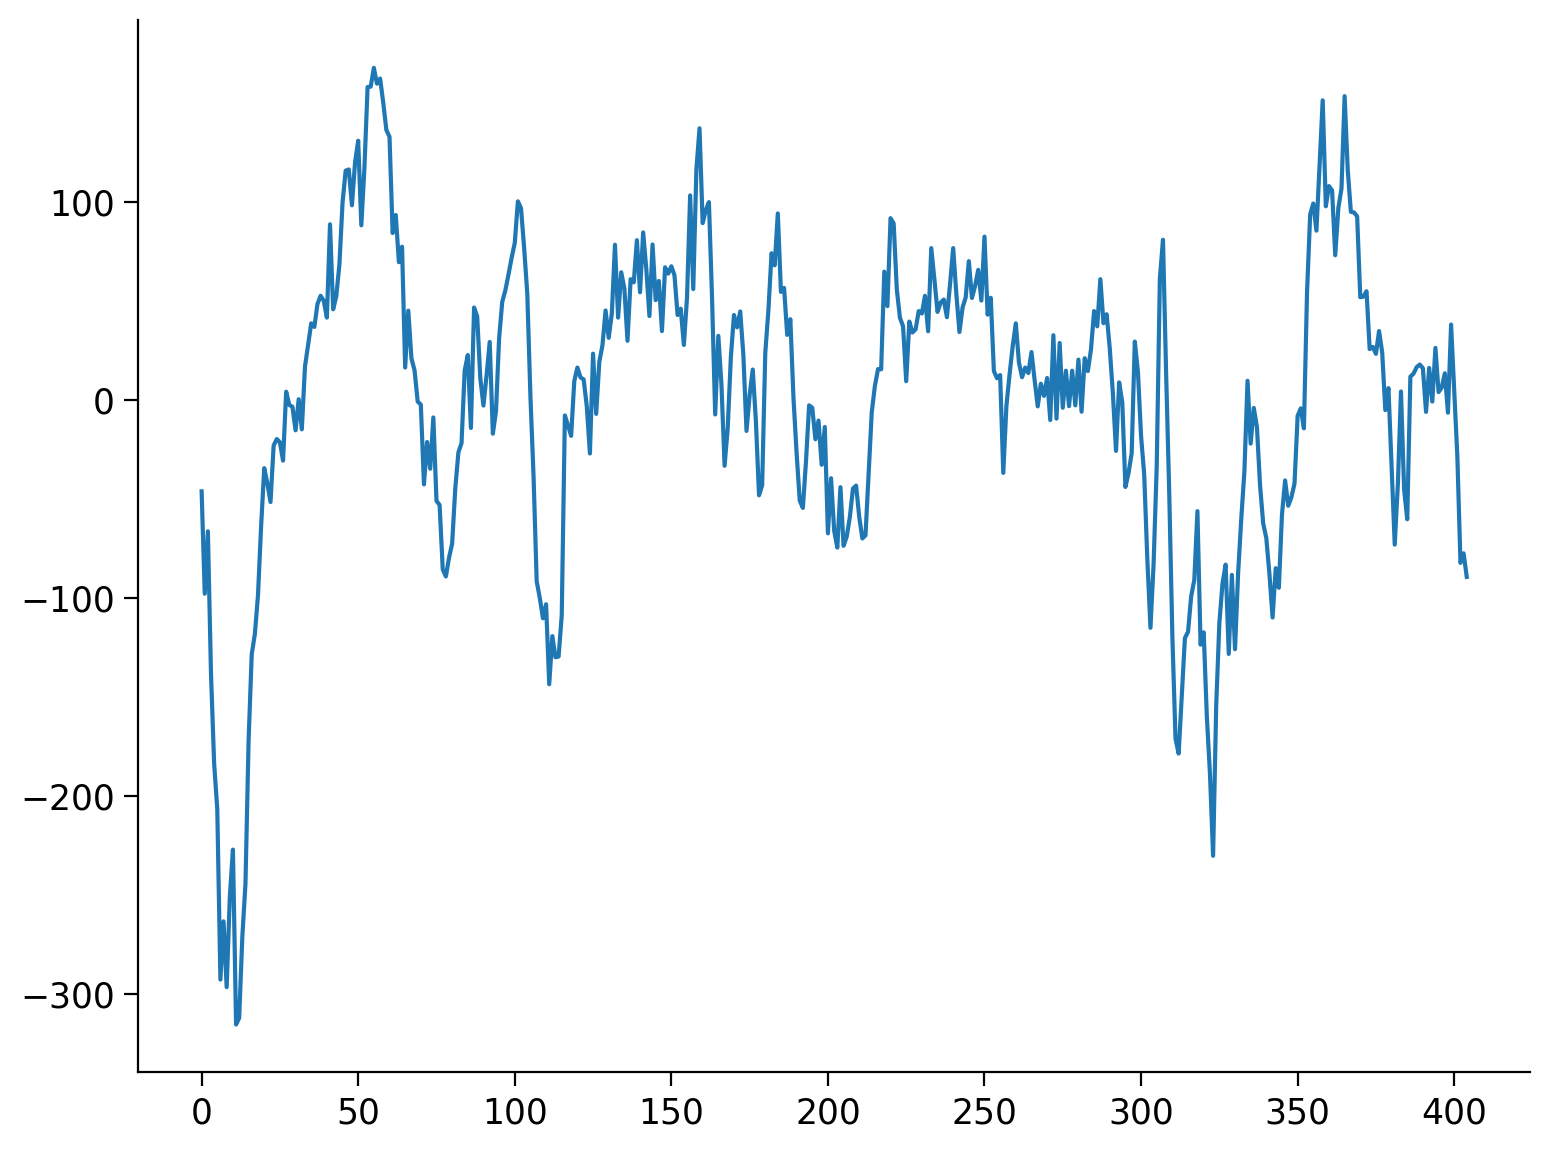

In [ ]:
plt.plot(ts0[0, :])

In [ ]:
# curious about a fun? use help()
help(load_timeseries)


Help on function load_timeseries in module __main__:

load_timeseries(subject, name, dir, runs=None, concat=True, remove_mean=True)
    Load timeseries data for a single subject.
    
    Args:
      subject (int): 0-based subject ID to load
      name (str) : Name of experiment ("rest" or name of task) to load
      dir (str) : data directory
      run (None or int or list of ints): 0-based run(s) of the task to load,
        or None to load all runs.
      concat (bool) : If True, concatenate multiple runs in time
      remove_mean (bool) : If True, subtract the parcel-wise mean
    
    Returns
      ts (n_parcel x n_tp array): Array of BOLD data values



## Concatenate conditions

This can be used to concatenate any number of conditions within any task. Just provide a list of all conditions you wanna concat and task id.

In [ ]:
help(get_conds)

Help on function get_conds in module __main__:

get_conds(subject, task, conds, concat=False, skip=0)
    Get timeseries for conditions of interest.
    Args:
    subject (int): subject id,
    task (string): task id ("wm", "gambling" etc.)
    conds (list): list of conditions to concatenate.
    concat (bool): If true, concatenate conditions instead of making a list.
    skip (int):  Ignore this many frames at the start of each trial, to account
        for hemodynamic lag
    Returns:
    ndarray (n_parcel x n_tp array) or list of ndarrays: Array of concatenated BOLD data values or a list of (not concatenated) data values.



In [ ]:
# list all 2-back conditions
two_back_conds = ['2bk_body', '2bk_faces', '2bk_places', '2bk_tools']

# list all 0-back conditions
no_back_conds = ['0bk_body', '0bk_faces', '0bk_places', '0bk_tools']

two_back, no_back = [], []
for s in subjects:
  two_back.append(get_conds(s, "wm", two_back_conds, concat=False))
  no_back.append(get_conds(s, "wm", no_back_conds, concat=False))



In [ ]:
two_back = np.array(two_back)
no_back = np.array(no_back)
two_back.shape

(339, 8, 360, 39)

In [ ]:
two_back_no_concatenate = two_back.transpose(0,1,2,3).reshape((339*8,360,39))
no_back_no_concatenate =  no_back.transpose(0,1,2,3).reshape((339*8,360,39))
no_back_no_concatenate.shape

(2712, 360, 39)

In [ ]:
two_back_fpn, no_back_fpn = extract_network_parcels(two_back_no_concatenate, no_back_no_concatenate, region_info, 'Frontopariet')

In [ ]:
two_back_fpn = np.array(two_back_fpn)
no_back_fpn = np.array(no_back_fpn)
two_back_fpn.shape

(2712, 50, 39)

In [ ]:
# help(extract_network_parcels)

In [ ]:
def split_train_test(_two_back, _no_back, split_Percentage = 70):
  split_Percentage = split_Percentage / 100
  n_train = int(split_Percentage * len(_two_back))
  print(n_train)
  _two_back_train = _two_back[0:n_train,:,:]
  _no_back_train = _no_back[0:n_train,:,:]
  _two_back_test = _two_back[n_train:,:,:]
  _no_back_test = _no_back[n_train:,:,:]
  return _no_back_train, _two_back_train, _no_back_test, _two_back_test

In [ ]:
no_back_train, two_back_train, no_back_test, two_back_test =  split_train_test(two_back_fpn, no_back_fpn)

1898


In [ ]:
from sklearn.utils import shuffle
n_train = len(no_back_train)
X_train = np.concatenate((no_back_train, two_back_train), axis = 0)
print(X_train.shape)
X_train = np.transpose(X_train, (0,2,1))
print(X_train.shape)
# Make label array
y_train = np.zeros(X_train.shape[0])
y_train[0:n_train] = 0
y_train[n_train:] = 1
X_train, y_train = shuffle(X_train, y_train, random_state=42)
print(y_train)

(3796, 50, 39)
(3796, 39, 50)
[0. 1. 0. ... 0. 1. 1.]


In [ ]:
from sklearn.utils import shuffle
n_test = len(no_back_test)
print(n_test)
X_test = np.concatenate((no_back_test, two_back_test), axis = 0)
print(X_test.shape)
X_test = np.transpose(X_test, (0,2,1))
print(X_test.shape)
# Make label array
y_test = np.zeros(X_test.shape[0])
y_test[0:n_test] = 0
y_test[n_test:] = 1
X_test, y_test = shuffle(X_test, y_test, random_state=42)
# print(y_test[:200])

814
(1628, 50, 39)
(1628, 39, 50)


In [ ]:
from sklearn.preprocessing import StandardScaler
scalers={}
for i in range(X_train.shape[2]):
  scalers[i] = StandardScaler()
  X_train[:,:,i] = scalers[i].fit_transform(X_train[:,:,i])
  X_test[:,:,i] = scalers[i].fit_transform(X_test[:,:,i])

In [ ]:
from sklearn.metrics import classification_report
from tensorflow import keras
import numpy as np

class CustomCallback(keras.callbacks.Callback):
    # def on_epoch_begin(self, epoch, logs=None):
    #     keys = list(logs.keys())
    #     print("Start epoch {} of training; got log keys: {}".format(epoch, keys))

    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        y_hat = model_GRU.predict(X_test)
        y_hat = np.where(y_hat>0.5,1,0)
        y_true = np.where(y_test>0.5,1,0)
        report = classification_report(y_true, y_hat)
        #print("End epoch {} of training; got log keys: {}".format(epoch, keys))
        print('\n', report)

In [ ]:
sequence_length = 39
n_signal = 50

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.layers import GRU, Dense, Input
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy

In [ ]:
inp = Input(shape = (sequence_length, n_signal))
first_layer = GRU(30, activation='relu', return_sequences=True)(inp)
second_layer = GRU(30, activation='relu', return_sequences=False)(first_layer)
# third_layer = GRU(3, activation='relu', return_sequences=False)(second_layer)
output = Dense(1, activation = 'sigmoid')(second_layer)

model_GRU = Model(inputs = inp, outputs = output)

model_GRU.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 39, 50)]          0         
                                                                 
 gru (GRU)                   (None, 39, 30)            7380      
                                                                 
 gru_1 (GRU)                 (None, 30)                5580      
                                                                 
 dense (Dense)               (None, 1)                 31        
                                                                 
Total params: 12991 (50.75 KB)
Trainable params: 12991 (50.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
opt = Adam(lr = 0.0001)
loss = binary_crossentropy
model_GRU.compile(optimizer = opt, loss = loss, metrics = 'acc')

In [ ]:
X_test.shape

(1628, 39, 50)

In [ ]:
results = model_GRU.fit(X_train, y_train, batch_size = 128, epochs = 10, validation_data = (X_test, y_test)
                    ,callbacks = [CustomCallback(), tf.keras.callbacks.TensorBoard(log_dir='./logs')])

Epoch 1/10
51/51 [==============================] - 1s 11ms/step

               precision    recall  f1-score   support

           0       0.74      0.86      0.79       814
           1       0.83      0.70      0.76       814

    accuracy                           0.78      1628
   macro avg       0.79      0.78      0.78      1628
weighted avg       0.79      0.78      0.78      1628

30/30 [==============================] - 3s 103ms/step - loss: 0.3104 - acc: 0.8425 - val_loss: 0.5178 - val_acc: 0.7783
Epoch 2/10
51/51 [==============================] - 0s 8ms/step

               precision    recall  f1-score   support

           0       0.79      0.76      0.77       814
           1       0.77      0.79      0.78       814

    accuracy                           0.78      1628
   macro avg       0.78      0.78      0.78      1628
weighted avg       0.78      0.78      0.78      1628

30/30 [==============================] - 2s 71ms/step - loss: 0.3049 - acc: 0.8393 - val_los

51/51 [==============================] - 0s 8ms/step
Confusion_matrix:  tf.Tensor(
[[627 187]
 [153 661]], shape=(2, 2), dtype=int32)


<Axes: >

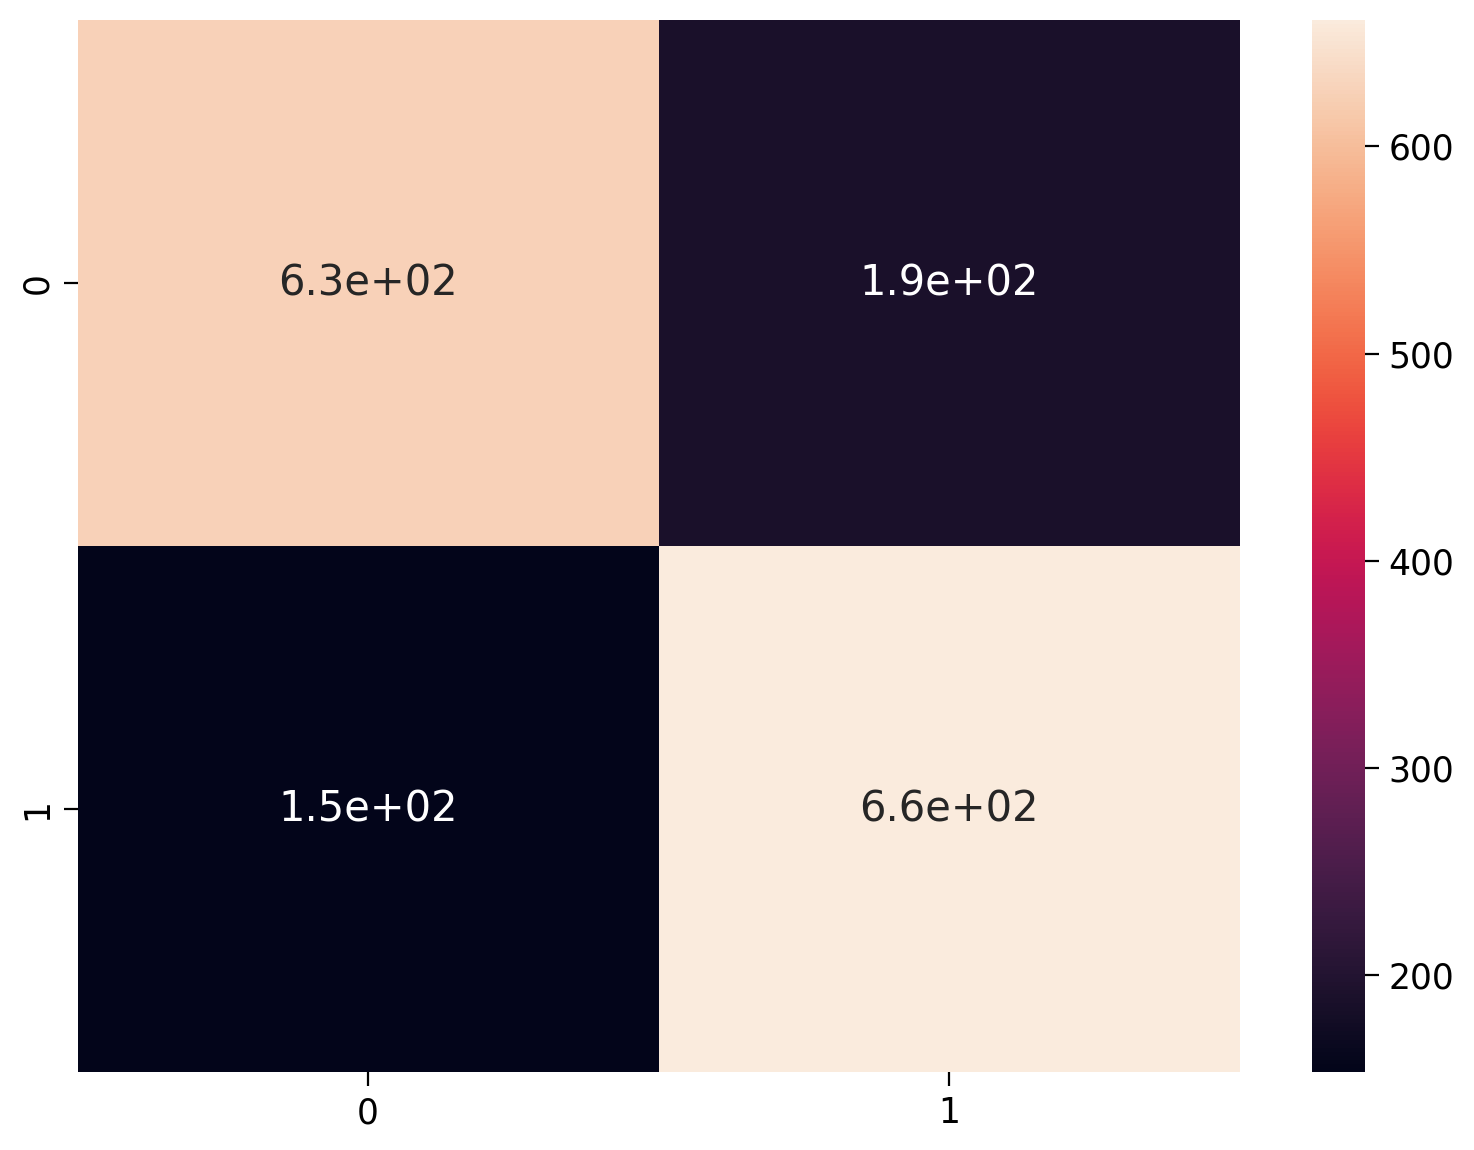

In [ ]:
# Evaluating confusion matrix
y_hat = model_GRU.predict(X_test)
y_hat = np.where(y_hat>0.5,1,0)
y_true = np.where(y_test>0.5,1,0)
cf_matrix = tf.math.confusion_matrix(y_true,y_hat)

# Printing the result
print('Confusion_matrix: ',cf_matrix)
import seaborn as sns
sns.heatmap(cf_matrix, annot=True)

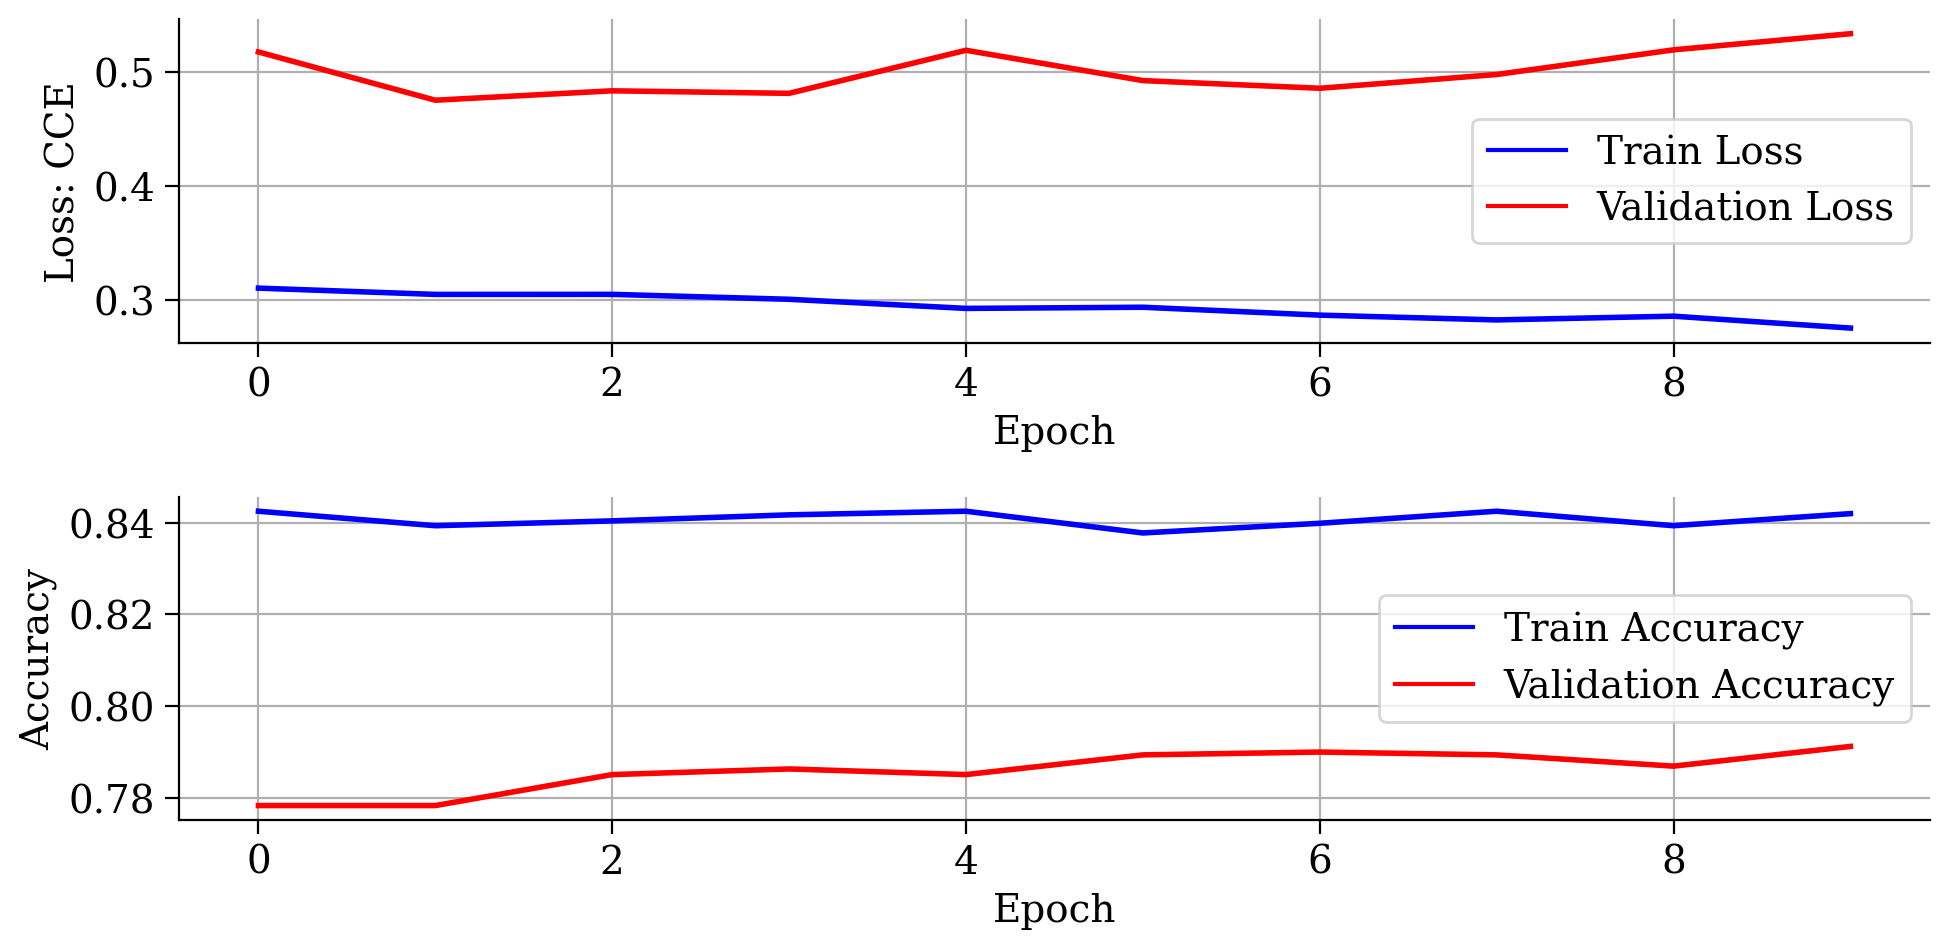

In [ ]:
import matplotlib.pyplot as plt
import matplotlib

# Set the font family to serif
matplotlib.rcParams['font.family'] = 'serif'

# Set the desired fontsize
fontsize = 14

train_loss = results.history['loss']
val_loss = results.history['val_loss']


# Create a figure with two subplots
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 5))

# Plot the train and validation loss in the top subplot
axs[0].plot(train_loss, label='Train Loss', color ='b')
axs[0].plot(val_loss, label='Validation Loss', color='r')

# Set the axis labels and title for the top subplot
axs[0].set_xlabel('Epoch', fontsize=fontsize)
axs[0].set_ylabel('Loss: CCE', fontsize=fontsize)
#axs[0].set_title('Training and Validation Loss', fontsize=fontsize)

# Set the legend and grid for the top subplot
axs[0].legend(fontsize=fontsize)
axs[0].grid(True)

# Set the tick labels fontsize for the top subplot
axs[0].tick_params(axis='both', which='major', labelsize=fontsize)

# Set the line colors and linewidths for the top subplot
axs[0].lines[0].set_linewidth(2)
axs[0].lines[1].set_linewidth(2)



train_acc =results.history['acc']
val_acc = results.history['val_acc']


# Plot the train and validation accuracy in the bottom subplot
axs[1].plot(train_acc, label='Train Accuracy', color ='b')
axs[1].plot(val_acc, label='Validation Accuracy', color='r')

# Set the axis labels and title for the bottom subplot
axs[1].set_xlabel('Epoch', fontsize=fontsize)
axs[1].set_ylabel('Accuracy', fontsize=fontsize)

# Set the legend and grid for the bottom subplot
axs[1].legend(fontsize=fontsize)
axs[1].grid(True)

# Set the tick labels fontsize for the bottom subplot
axs[1].tick_params(axis='both', which='major', labelsize=fontsize)

# Set the line colors and linewidths for the bottom subplot
axs[1].lines[0].set_linewidth(2)
axs[1].lines[1].set_linewidth(2)

# Adjust the spacing between the subplots
fig.tight_layout()

# Show the plot
plt.show()
